In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import cPickle as pickle
import io
%matplotlib inline
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn import grid_search
#import cPickle as pickle
#import io

In [2]:
def write_to_file(filename, predictions):
    with open(filename, "w") as f:
        f.write("Id,Prediction\n")
        for i,p in enumerate(predictions):
            f.write(str(i+1) + "," + str(p) + "\n")

In [3]:
# Run this if in rd environment
from __future__ import print_function
from rdkit import Chem

In [4]:
"""
Read in train and test as Pandas DataFrames
"""
df_train = pd.read_csv("../train.csv")
df_test = pd.read_csv("../test.csv")

In [5]:
df_train.head()

,smiles,feat_001,feat_002,feat_003,feat_004,feat_005,feat_006,feat_007,feat_008,feat_009,...,feat_248,feat_249,feat_250,feat_251,feat_252,feat_253,feat_254,feat_255,feat_256,gap
0,c1ccc(o1)-c1ccc(s1)-c1cnc(-c2scc3[se]ccc23)c2n...,0,0,0,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1.19
1,C1=CC=C(C1)c1cc2ncc3c4[SiH2]C=Cc4ncc3c2c2=C[Si...,1,0,0,0,1,0,1,0,0,...,1,0,0,1,0,0,0,0,0,1.60
2,[nH]1c-2c([SiH2]c3cc(-c4scc5C=CCc45)c4nsnc4c-2...,1,0,0,0,1,1,1,0,0,...,1,0,0,0,1,0,0,0,0,1.49
3,[nH]1c2-c3occc3Cc2c2c1cc(-c1cccc3=C[SiH2]C=c13...,1,0,0,0,1,1,1,0,0,...,1,0,0,0,1,0,0,0,0,1.36
4,c1cnc2c3oc4cc(-c5ncncn5)c5nsnc5c4c3c3cocc3c2c1,0,0,0,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1.98


In [6]:
df_test.head()

,Id,smiles,feat_001,feat_002,feat_003,feat_004,feat_005,feat_006,feat_007,feat_008,...,feat_247,feat_248,feat_249,feat_250,feat_251,feat_252,feat_253,feat_254,feat_255,feat_256
0,1,c1sc(-c2cnc3c(c2)c2nsnc2c2cc4cccnc4cc32)c2cc[n...,0,0,0,0,1,1,1,0,...,0,1,0,0,0,0,0,0,0,0
1,2,[nH]1cccc1-c1cc2c3nsnc3c3c4sccc4[nH]c3c2s1,0,0,0,0,1,1,1,0,...,0,1,0,0,0,0,0,0,0,0
2,3,[nH]1c2cc(-c3ccc[se]3)c3nsnc3c2c2c3cscc3c3ccc4...,1,0,0,0,1,1,1,0,...,0,1,0,0,0,0,0,0,0,0
3,4,[nH]1c(cc2cnc3c(c12)c1=C[SiH2]C=c1c1ccc2=CCC=c...,1,0,0,0,1,1,1,0,...,0,1,0,0,0,0,0,0,0,0
4,5,c1sc(-c2sc(-c3sc(-c4scc5[se]ccc45)c4ccoc34)c3c...,0,0,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0


In [7]:
#store gap values
Y_train = df_train.gap.values
#row where testing examples start
test_idx = df_train.shape[0]
#delete 'Id' column
df_test = df_test.drop(['Id'], axis=1)
#delete 'gap' column
df_train = df_train.drop(['gap'], axis=1)

In [8]:
#DataFrame with all train and test examples so we can more easily apply feature engineering on
df_all = pd.concat((df_train, df_test), axis=0)
df_all.head()

,smiles,feat_001,feat_002,feat_003,feat_004,feat_005,feat_006,feat_007,feat_008,feat_009,...,feat_247,feat_248,feat_249,feat_250,feat_251,feat_252,feat_253,feat_254,feat_255,feat_256
0,c1ccc(o1)-c1ccc(s1)-c1cnc(-c2scc3[se]ccc23)c2n...,0,0,0,0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1,C1=CC=C(C1)c1cc2ncc3c4[SiH2]C=Cc4ncc3c2c2=C[Si...,1,0,0,0,1,0,1,0,0,...,0,1,0,0,1,0,0,0,0,0
2,[nH]1c-2c([SiH2]c3cc(-c4scc5C=CCc45)c4nsnc4c-2...,1,0,0,0,1,1,1,0,0,...,0,1,0,0,0,1,0,0,0,0
3,[nH]1c2-c3occc3Cc2c2c1cc(-c1cccc3=C[SiH2]C=c13...,1,0,0,0,1,1,1,0,0,...,0,1,0,0,0,1,0,0,0,0
4,c1cnc2c3oc4cc(-c5ncncn5)c5nsnc5c4c3c3cocc3c2c1,0,0,0,0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


In [9]:
"""
Example Feature Engineering

this calculates the length of each smile string and adds a feature column with those lengths
Note: this is NOT a good feature and will result in a lower score!
"""
#smiles_len = np.vstack(df_all.smiles.astype(str).apply(lambda x: len(x)))
#df_all['smiles_len'] = pd.DataFrame(smiles_len)


'\nExample Feature Engineering\n\nthis calculates the length of each smile string and adds a feature column with those lengths\nNote: this is NOT a good feature and will result in a lower score!\n'

#### Create new variables using RDKit

In [10]:
# Create functions to get the number of Aromatic, Single, and Double Bonds for a given molecule

def getAromatic(m):
    bonds = []
    for bond_type in m.GetBonds():
        num_Aromatic = 0
        bonds.append(str(bond_type.GetBondType()))
    num_Aromatic = bonds.count('AROMATIC')
    return(num_Aromatic)

def getSingle(m):
    bonds = []
    for bond_type in m.GetBonds():
        num_Single = 0
        bonds.append(str(bond_type.GetBondType()))
    num_Single = bonds.count('SINGLE')
    return(num_Single)

def getDouble(m):
    bonds = []
    for bond_type in m.GetBonds():
        num_Double = 0
        bonds.append(str(bond_type.GetBondType()))
    num_Double = bonds.count('DOUBLE')
    return(num_Double)

In [11]:
#getDouble(Chem.MolFromSmiles(df_train['smiles'][2]))

1

In [14]:
df_new = df_all.copy()
df_new['NumDouble'] = df_new['smiles'].apply(lambda x: getDouble(Chem.MolFromSmiles(x)))

In [15]:
df_new['NumSingle'] = df_new['smiles'].apply(lambda x: getSingle(Chem.MolFromSmiles(x)))

In [16]:
df_new['NumAromatic'] = df_new['smiles'].apply(lambda x: getAromatic(Chem.MolFromSmiles(x)))

In [21]:
df_new['NumAtoms'] = df_new['smiles'].apply(lambda x: Chem.MolFromSmiles(x).GetNumAtoms())

In [22]:
df_new['NumBonds'] = df_new['smiles'].apply(lambda x: Chem.MolFromSmiles(x).GetNumBonds())

In [25]:
df_new.head()

,smiles,feat_001,feat_002,feat_003,feat_004,feat_005,feat_006,feat_007,feat_008,feat_009,...,feat_252,feat_253,feat_254,feat_255,feat_256,NumDouble,NumSingle,NumAromatic,NumAtoms,NumBonds
0,c1ccc(o1)-c1ccc(s1)-c1cnc(-c2scc3[se]ccc23)c2n...,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,3,29,27,32
1,C1=CC=C(C1)c1cc2ncc3c4[SiH2]C=Cc4ncc3c2c2=C[Si...,1,0,0,0,1,0,1,0,0,...,0,0,0,0,0,5,9,16,25,30
2,[nH]1c-2c([SiH2]c3cc(-c4scc5C=CCc45)c4nsnc4c-2...,1,0,0,0,1,1,1,0,0,...,1,0,0,0,0,1,7,25,27,33
3,[nH]1c2-c3occc3Cc2c2c1cc(-c1cccc3=C[SiH2]C=c13...,1,0,0,0,1,1,1,0,0,...,1,0,0,0,0,4,8,21,27,33
4,c1cnc2c3oc4cc(-c5ncncn5)c5nsnc5c4c3c3cocc3c2c1,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,1,34,29,35


In [25]:
# Make a copy of df_all, add NumAtoms and NumBonds
# Drop smiles column
df_new = df_all.copy()
df_new['NumDouble'] = df_new['smiles'].apply(lambda x: getDouble(Chem.MolFromSmiles(x)))
df_new['NumSingle'] = df_new['smiles'].apply(lambda x: getSingle(Chem.MolFromSmiles(x)))
df_new['NumAromatic'] = df_new['smiles'].apply(lambda x: getAromatic(Chem.MolFromSmiles(x)))
df_new['NumAtoms'] = df_new['smiles'].apply(lambda x: Chem.MolFromSmiles(x).GetNumAtoms())
df_new['NumBonds'] = df_new['smiles'].apply(lambda x: Chem.MolFromSmiles(x).GetNumBonds())

df_new = df_new.drop(['smiles'], axis=1)

vals_new = df_new.values
X_train_new = vals_new[:test_idx]
X_test_new = vals_new[test_idx:]

In [3]:
# Save the new datasets (as an array of arrays)
#np.save('X_train_new_bonds', X_train_new_bonds)
#np.save('X_test_new_bonds', X_test_new_bonds)
#np.save('Y_train', Y_train)

# Load the dataset (as an array of arrays)
X_train = np.load('X_train_new.npy')
X_test = np.load('X_test_new.npy')
Y_train = np.load('Y_train.npy')

##### Plot new features v. outcomes

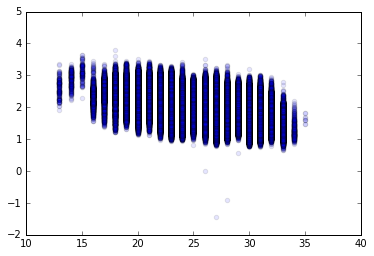

In [34]:
# EDA:  How is the new variable "NumAtoms" vs. Y?
# Slight downwards trend
plt.scatter(df_new[:test_idx]['NumAtoms'], Y_train, alpha=.1)

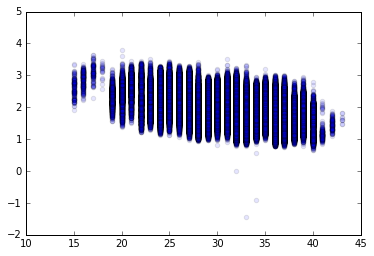

In [35]:
# EDA:  How is the new variable "NumBonds" vs. Y?
# Slight downwards trend
plt.scatter(df_new[:test_idx]['NumBonds'], Y_train, alpha=.1)

Conclusion:  No reason to make a new basis function

####LINEAR REGRESSION

In [4]:
LR = LinearRegression()
LR.fit(X_train, Y_train)
LR_pred = LR.predict(X_test)
LR_pred
plt.hist(LR_pred, bins=50)
plt.show()

array([ 1.62912398,  1.85625559,  1.42804268, ...,  1.67208692,
        1.70218401,  1.90044013])

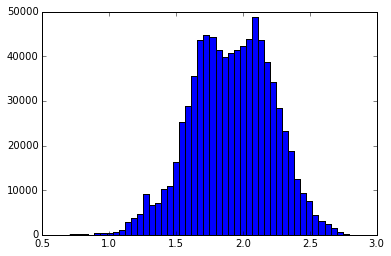

In [9]:
plt.hist(LR_pred, bins=50)
plt.show()

####LASSO REGRESSION

In [24]:
# Try Lasso Regression on New Dataset
# Use alpha = 1
clf_lasso = linear_model.Lasso(alpha=1)
clf_lass.fit(X_train, Y_train)
lasso_pred = clf_lass.predict(X_test)
lasso_pred

array([ 1.91572618,  1.91572618,  1.91572618, ...,  1.91572618,
        1.91572618,  1.91572618])

All the predictions are the same! Let's try a smaller alpha

In [22]:
# Try Lasso Regression on New Dataset
# Use alpha = 0.01
from sklearn import linear_model
clf_lasso = linear_model.Lasso(alpha=0.01)
clf_lasso.fit(X_train, Y_train)
lasso_pred2 = clf_lasso.predict(X_test)
lasso_pred2

array([ 1.7587643 ,  2.01732128,  1.39757913, ...,  1.82542497,
        1.69660118,  1.9448515 ])

Try optimizing the alpha parameter using grid_search

In [47]:
# Try to optimize the parameter alpha
parameters = {'alpha':[1, 50, 100, 500]}
lasso = linear_model.Lasso()
clf_lasso = grid_search.GridSearchCV(estimator=lasso, param_grid=parameters)
clf_lasso.fit(X_train,Y_train)
print clf_lasso.grid_scores_
print clf_lasso.best_score_

[mean: -0.00001, std: 0.00000, params: {'alpha': 1}, mean: -0.00001, std: 0.00000, params: {'alpha': 50}, mean: -0.00001, std: 0.00000, params: {'alpha': 100}, mean: -0.00001, std: 0.00000, params: {'alpha': 500}]
-6.37181767329e-06


In [16]:
# Try to optimize the parameter alpha
parameters = {'alpha':[0.2, 0.4, 0.6, 0.8, 1]}
lasso = linear_model.Lasso()
clf_lasso = grid_search.GridSearchCV(estimator=lasso, param_grid=parameters)
clf_lasso.fit(X_train,Y_train)
print clf_lasso.grid_scores_
print clf_lasso.best_score_

[mean: 0.18103, std: 0.00043, params: {'alpha': 0.2}, mean: 0.13411, std: 0.00011, params: {'alpha': 0.4}, mean: 0.05590, std: 0.00033, params: {'alpha': 0.6}, mean: -0.00001, std: 0.00000, params: {'alpha': 0.8}, mean: -0.00001, std: 0.00000, params: {'alpha': 1}]
0.181030320218


In [18]:
parameters = {'alpha':[0.05, 0.1, 0.15, 0.2]}
clf_lasso = grid_search.GridSearchCV(estimator=lasso, param_grid=parameters)
clf_lasso.fit(X_train,Y_train)
print clf_lasso.grid_scores_
print clf_lasso.best_score_

[mean: 0.28614, std: 0.00054, params: {'alpha': 0.05}, mean: 0.19276, std: 0.00055, params: {'alpha': 0.1}, mean: 0.18787, std: 0.00049, params: {'alpha': 0.15}, mean: 0.18103, std: 0.00043, params: {'alpha': 0.2}]
0.286135935156


In [19]:
parameters = {'alpha':[0.01, 0.02, 0.03, 0.04, 0.05]}
clf_lasso = grid_search.GridSearchCV(estimator=lasso, param_grid=parameters)
clf_lasso.fit(X_train,Y_train)
print clf_lasso.grid_scores_
print clf_lasso.best_score_

[mean: 0.47963, std: 0.00073, params: {'alpha': 0.01}, mean: 0.42541, std: 0.00045, params: {'alpha': 0.02}, mean: 0.38357, std: 0.00033, params: {'alpha': 0.03}, mean: 0.33971, std: 0.00045, params: {'alpha': 0.04}, mean: 0.28614, std: 0.00054, params: {'alpha': 0.05}]
0.479634807816


In [20]:
parameters = {'alpha':[0.002, 0.004, 0.006, 0.008, 0.01]}
clf_lasso = grid_search.GridSearchCV(estimator=lasso, param_grid=parameters)
clf_lasso.fit(X_train,Y_train)
print clf_lasso.grid_scores_
print clf_lasso.best_score_

[mean: 0.53501, std: 0.00097, params: {'alpha': 0.002}, mean: 0.51697, std: 0.00068, params: {'alpha': 0.004}, mean: 0.50582, std: 0.00074, params: {'alpha': 0.006}, mean: 0.49332, std: 0.00073, params: {'alpha': 0.008}, mean: 0.47963, std: 0.00073, params: {'alpha': 0.01}]
0.535008954993


In [46]:
clf_lasso

GridSearchCV(cv=None, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, solver='auto', tol=0.001),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'alpha': [0.2, 0.4, 0.6, 0.8, 1]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

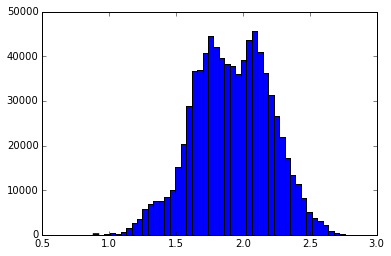

In [23]:
clf_lasso = linear_model.Lasso(alpha=0.002)
clf_lasso.fit(X_train, Y_train)
lasso_pred3 = clf_lasso.predict(X_test)
plt.hist(lasso_pred3, bins=50)
plt.show()

In [ ]:
write_to_file("lasso3.csv", lasso_pred3)

####RIDGE REGRESSION

In [51]:
# Try to optimize the parameter alpha
parameters = {'alpha':[1, 50, 100, 500, 1000]}
ridge = Ridge()
clf_ridge = grid_search.GridSearchCV(estimator=ridge, param_grid=parameters)
clf_ridge.fit(X_train,Y_train)
print clf_ridge.grid_scores_
print clf_ridge.best_score_

[mean: 0.54500, std: 0.00125, params: {'alpha': 1}, mean: 0.54499, std: 0.00125, params: {'alpha': 50}, mean: 0.54498, std: 0.00124, params: {'alpha': 100}, mean: 0.54480, std: 0.00120, params: {'alpha': 500}, mean: 0.54446, std: 0.00117, params: {'alpha': 1000}]
0.545000526565


In [27]:
# Try to optimize the parameter alpha
parameters = {'alpha':[0.2, 0.4, 0.6, 0.8, 1]}
ridge = Ridge()
clf_ridge = grid_search.GridSearchCV(estimator=ridge, param_grid=parameters)
clf_ridge.fit(X_train,Y_train)
print clf_ridge.grid_scores_
print clf_ridge.best_score_

[mean: 0.54500, std: 0.00125, params: {'alpha': 0.2}, mean: 0.54500, std: 0.00125, params: {'alpha': 0.4}, mean: 0.54500, std: 0.00125, params: {'alpha': 0.6}, mean: 0.54500, std: 0.00125, params: {'alpha': 0.8}, mean: 0.54500, std: 0.00125, params: {'alpha': 1}]
0.545000526565


In [28]:
parameters = {'alpha':[0.05, 0.1, 0.15, 0.2]}
ridge = Ridge()
clf_ridge = grid_search.GridSearchCV(estimator=ridge, param_grid=parameters)
clf_ridge.fit(X_train,Y_train)
print clf_ridge.grid_scores_
print clf_ridge.best_score_

[mean: 0.54500, std: 0.00125, params: {'alpha': 0.05}, mean: 0.54500, std: 0.00125, params: {'alpha': 0.1}, mean: 0.54500, std: 0.00125, params: {'alpha': 0.15}, mean: 0.54500, std: 0.00125, params: {'alpha': 0.2}]
0.544999385082


In [29]:
parameters = {'alpha':[0.002, 0.004, 0.006, 0.008, 0.01]}
ridge = Ridge()
clf_ridge = grid_search.GridSearchCV(estimator=ridge, param_grid=parameters)
clf_ridge.fit(X_train,Y_train)
print clf_ridge.grid_scores_
print clf_ridge.best_score_

[mean: 0.54500, std: 0.00125, params: {'alpha': 0.002}, mean: 0.54500, std: 0.00125, params: {'alpha': 0.004}, mean: 0.54500, std: 0.00125, params: {'alpha': 0.006}, mean: 0.54500, std: 0.00125, params: {'alpha': 0.008}, mean: 0.54500, std: 0.00125, params: {'alpha': 0.01}]
0.544999032509


[ 1.62925811  1.85660778  1.4270343  ...,  1.67223462  1.70234101
  1.90055676]


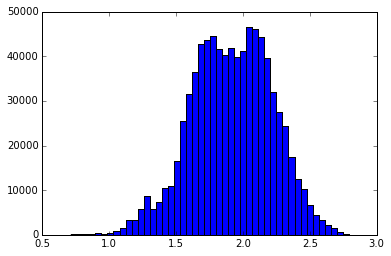

In [55]:
clf_ridge = Ridge(alpha=100)
clf_ridge.fit(X_train, Y_train) 
clf_pred_ridge = clf_ridge.predict(X_test)
print clf_pred_ridge
plt.hist(clf_pred_ridge, bins=50)
plt.show()

In [56]:
clf_ridge.coef_

array([ 0.01550383,  0.        ,  0.        ,  0.        ,  0.04340134,
        0.01305603,  0.0735963 ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.07804921,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.15139703,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.23346514,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.16127569, -0.17747713,  0.  

[ 1.62868979  1.85603658  1.42718808 ...,  1.67162963  1.70255992
  1.90012889]


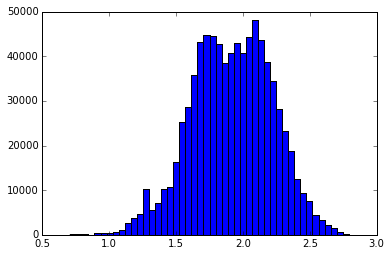

In [34]:
clf_ridge = Ridge(alpha=1)
clf_ridge.fit(X_train, Y_train) 
clf_pred_ridge = clf_ridge.predict(X_test)
print clf_pred_ridge
plt.hist(clf_pred_ridge, bins=50)
plt.show()

In [45]:
clf_ridge.coef_

array([ 0.01557563,  0.        ,  0.        ,  0.        ,  0.36917634,
        0.01318311,  0.22344066,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.07662161,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.16702768,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.23904925,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.16177453, -0.19324415,  0.  

[ 1.62868381  1.8560324   1.42718985 ...,  1.67162345  1.70256318
  1.90012442]


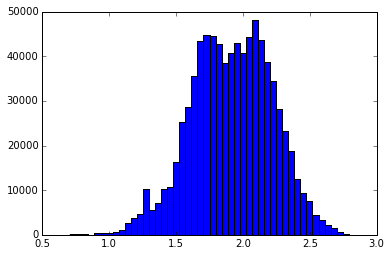

In [36]:
clf_ridge = Ridge(alpha=0.1)
clf_ridge.fit(X_train, Y_train) 
clf_pred_ridge2 = clf_ridge.predict(X_test)
print clf_pred_ridge2
plt.hist(clf_pred_ridge2, bins=50)
plt.show()

In [11]:
write_to_file("Ridge_new.csv", clf_pred_ridge2)

####ELASTIC NET

In [37]:
# Elastic Net
clf_EN = ElasticNet(alpha=1)
clf_EN.fit(X_train, Y_train)
clf_pred_EN = clf_EN.predict(X_test)
clf_pred_EN

array([ 1.87918742,  1.97114621,  1.83977651, ...,  1.90546136,
        1.90546136,  1.94487227])

In [40]:
# Elastic Net
clf_EN = ElasticNet(alpha=1, l1_ratio=0.2)
clf_EN.fit(X_train, Y_train)
clf_pred_EN = clf_EN.predict(X_test)
clf_pred_EN

array([ 1.82843554,  2.04812394,  1.73428337, ...,  1.89120365,
        1.89120365,  1.98535582])

In [41]:
parameters = {'l1_ratio':[0.2, 0.4, 0.5, 0.8, 1], 'alpha':[0.2, 0.4, 0.6, 0.8, 1]}
en = ElasticNet()
clf_en = grid_search.GridSearchCV(estimator=en, param_grid=parameters)
clf_en.fit(X_train,Y_train)
print clf_en.grid_scores_
print clf_en.best_score_

[mean: 0.28817, std: 0.00053, params: {'alpha': 0.2, 'l1_ratio': 0.2}, mean: 0.19386, std: 0.00057, params: {'alpha': 0.2, 'l1_ratio': 0.4}, mean: 0.19245, std: 0.00055, params: {'alpha': 0.2, 'l1_ratio': 0.5}, mean: 0.18648, std: 0.00048, params: {'alpha': 0.2, 'l1_ratio': 0.8}, mean: 0.18103, std: 0.00043, params: {'alpha': 0.2, 'l1_ratio': 1}, mean: 0.19331, std: 0.00056, params: {'alpha': 0.4, 'l1_ratio': 0.2}, mean: 0.18558, std: 0.00047, params: {'alpha': 0.4, 'l1_ratio': 0.4}, mean: 0.17999, std: 0.00042, params: {'alpha': 0.4, 'l1_ratio': 0.5}, mean: 0.15613, std: 0.00025, params: {'alpha': 0.4, 'l1_ratio': 0.8}, mean: 0.13411, std: 0.00011, params: {'alpha': 0.4, 'l1_ratio': 1}, mean: 0.18925, std: 0.00051, params: {'alpha': 0.6, 'l1_ratio': 0.2}, mean: 0.17209, std: 0.00036, params: {'alpha': 0.6, 'l1_ratio': 0.4}, mean: 0.15962, std: 0.00027, params: {'alpha': 0.6, 'l1_ratio': 0.5}, mean: 0.10591, std: 0.00006, params: {'alpha': 0.6, 'l1_ratio': 0.8}, mean: 0.05590, std: 0.0

In [ ]:
parameters = {'l1_ratio':[0, 0.25, 0.5, 0.75, 1], 'alpha':[.1, 1, 10, 100]}
en = ElasticNet()
clf_en = grid_search.GridSearchCV(estimator=en, param_grid=parameters)
clf_en.fit(X_train,Y_train)
print clf_en.grid_scores_
print clf_en.best_score_

[mean: 0.49489, std: 0.00049, params: {'alpha': 0.1, 'l1_ratio': 0}, mean: 0.37716, std: 0.00032, params: {'alpha': 0.1, 'l1_ratio': 0.25}, mean: 0.27313, std: 0.00056, params: {'alpha': 0.1, 'l1_ratio': 0.5}, mean: 0.20514, std: 0.00075, params: {'alpha': 0.1, 'l1_ratio': 0.75}, mean: 0.19276, std: 0.00055, params: {'alpha': 0.1, 'l1_ratio': 1}, mean: 0.33584, std: 0.00053, params: {'alpha': 1, 'l1_ratio': 0}, mean: 0.16789, std: 0.00033, params: {'alpha': 1, 'l1_ratio': 0.25}, mean: 0.09633, std: 0.00010, params: {'alpha': 1, 'l1_ratio': 0.5}, mean: -0.00001, std: 0.00000, params: {'alpha': 1, 'l1_ratio': 0.75}, mean: -0.00001, std: 0.00000, params: {'alpha': 1, 'l1_ratio': 1}, mean: 0.20589, std: 0.00045, params: {'alpha': 10, 'l1_ratio': 0}, mean: -0.00001, std: 0.00000, params: {'alpha': 10, 'l1_ratio': 0.25}, mean: -0.00001, std: 0.00000, params: {'alpha': 10, 'l1_ratio': 0.5}, mean: -0.00001, std: 0.00000, params: {'alpha': 10, 'l1_ratio': 0.75}, mean: -0.00001, std: 0.00000, params: {'alpha': 10, 'l1_ratio': 1}, mean: 0.07476, std: 0.00009, params: {'alpha': 100, 'l1_ratio': 0}, mean: -0.00001, std: 0.00000, params: {'alpha': 100, 'l1_ratio': 0.25}, mean: -0.00001, std: 0.00000, params: {'alpha': 100, 'l1_ratio': 0.5}, mean: -0.00001, std: 0.00000, params: {'alpha': 100, 'l1_ratio': 0.75}, mean: -0.00001, std: 0.00000, params: {'alpha': 100, 'l1_ratio': 1}]
0.494892601698

####RANDOM FOREST

[ 1.79886623  1.93589733  1.41166692 ...,  1.30407073  1.53748225
  2.04997036]


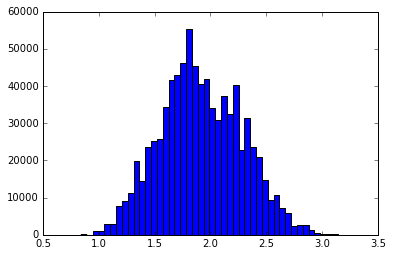

In [56]:
RF = RandomForestRegressor(n_estimators=100)
RF.fit(X_train, Y_train)
RF_pred = RF.predict(X_test)
print(RF_pred)
plt.hist(RF_pred, bins=50)
plt.show()

In [57]:
write_to_file("RF_pred_new_bonds.csv", RF_pred)